Future needs for project:
- Input try/exception into the API call to account for errors (limit exceeded, etc.)
- random date generator to get weather data for dates that weren't associated with fires
- rolling totals/avg as predictors for the following - precipitation sum (maybe 30 day rolling, percentage of days it rained multiplied by total amount), average relative humidity (weekly lag?), and adding in evapotranspiration. 

In [1]:
# imports and installs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import requests
from datetime import datetime
from datetime import timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Reading in historical fire data. 
record_length = 1000
directory = "/Users/coleparker/Documents/Udemy/Personal Challenges/Fire_Prediction/"
file_name = "Fire_Occurrence_Data_2000_2022.csv"

df_fire_full = pd.read_csv(directory + file_name)
df_fire_drop = df_fire_full.drop(["Serial", "FireCategory", "Area", "DistrictName", "UnitName", "FullFireNumber", "Cause_Comments", "LatLongDD", "FO_LandOwnType",
                   "Twn", "Rng", "Sec", "Subdiv", "LandmarkLocation", "County", "RegUseZone", "RegUseRestriction", "Industrial_Restriction",
                   "DistrictCode", "UnitCode", "DistFireNumber"], axis = 1)
df_fire_drop.sort_values(["ReportDateTime"], inplace = True, ascending = False)
df_fire_drop = df_fire_drop[:record_length]

df_fire_drop = df_fire_drop.dropna()

df_fire_drop['Ign_DateTime'] = pd.to_datetime(df_fire_drop['Ign_DateTime'], format = '%m/%d/%Y %I:%M:%S %p')
df_fire_drop['Control_DateTime'] = pd.to_datetime(df_fire_drop['Control_DateTime'], format = '%m/%d/%Y %I:%M:%S %p')

df_fire_drop = df_fire_drop.drop(df_fire_drop.index[df_fire_drop['Control_DateTime'] < df_fire_drop['Ign_DateTime']].tolist())

In [19]:
# Function for generating random dates not present in original fire dataset.
# To be used for weather data not assigned fires. 
def rand_date(input_df, record_length = 1000):
    minimum_date = input_df['date'].min()
    maximum_date = input_df['date'].max()

    listed_date = [minimum_date]
    new_dates = []

    while minimum_date != maximum_date:
        minimum_date += timedelta(days = 1)
        if minimum_date in input_df['date']:
            pass
        else:
            listed_date.append(minimum_date)
    
    for i in range(record_length):
        rand_num = np.random.randint(0, len(listed_date))
        curr_date = listed_date[rand_num]
        new_dates.append(curr_date)

    return pd.Series(new_dates)

In [35]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 1)
openmeteo = openmeteo_requests.Client(session = retry_session)

hourly_dataframe_agg = pd.DataFrame()
daily_dataframe_agg = pd.DataFrame()

try:
    for point in tqdm(range(len(df_fire_drop))):
        lat_current = df_fire_drop["Lat_DD"].iloc[point]
        long_current = df_fire_drop["Long_DD"].iloc[point]

        # Make sure all required weather variables are listed here
        # The order of variables in hourly or daily is important to assign them correctly below
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": lat_current,
            "longitude": long_current,
            "start_date": datetime.strftime(df_fire_drop['Ign_DateTime'].iloc[point].date(), '%Y-%m-%d'),
            "end_date": datetime.strftime(df_fire_drop['Control_DateTime'].iloc[point].date(), '%Y-%m-%d'),
            "hourly": ["relative_humidity_2m", "soil_moisture_0_to_7cm", "soil_moisture_28_to_100cm", 
                "soil_temperature_0_to_7cm", "soil_temperature_28_to_100cm",
                "surface_pressure"],
            "daily": ["temperature_2m_mean", "wind_speed_10m_max", 
                "wind_gusts_10m_max", "wind_direction_10m_dominant",
                "rain_sum", "et0_fao_evapotranspiration"],
            "temperature_unit": "fahrenheit",
            "wind_speed_unit": "mph",
            "precipitation_unit": "inch",
            "timezone": "America/Los_Angeles"
        }
        responses = openmeteo.weather_api(url, params=params)

        response = responses[0]

        # Process hourly data. The order of variables needs to be the same as requested.
        hourly = response.Hourly()
        hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()
        hourly_soil_moisture_0_to_7cm = hourly.Variables(1).ValuesAsNumpy()
        hourly_soil_moisture_28_to_100cm = hourly.Variables(2).ValuesAsNumpy()  
        hourly_soil_temperature_0_to_7cm = hourly.Variables(3).ValuesAsNumpy()
        hourly_soil_temperature_28_to_100cm = hourly.Variables(4).ValuesAsNumpy()
        hourly_surface_pressure = hourly.Variables(5).ValuesAsNumpy()

        hourly_data = {"date": pd.date_range(
            start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
            end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
            freq = pd.Timedelta(seconds = hourly.Interval()),
            inclusive = "left"
        )}
        hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
        hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
        hourly_data["soil_moisture_28_to_100cm"] = hourly_soil_moisture_28_to_100cm
        hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
        hourly_data["soil_temperature_28_to_100cm"] = hourly_soil_temperature_28_to_100cm
        hourly_data["surface_pressure"] = hourly_surface_pressure
        
        hourly_dataframe = pd.DataFrame(data = hourly_data)
        df_fire_drop_repeat_hour = pd.DataFrame(np.tile(df_fire_drop.iloc[point].values, (len(hourly_dataframe), 1)), columns = df_fire_drop.columns)
        hourly_dataframe = pd.concat([hourly_dataframe, df_fire_drop_repeat_hour], axis=1)
        hourly_dataframe_agg = pd.concat([hourly_dataframe_agg, hourly_dataframe], ignore_index=True, axis=0)

        # Process daily data. The order of variables needs to be the same as requested.
        daily = response.Daily()
        daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
        daily_wind_speed_10m_max = daily.Variables(1).ValuesAsNumpy()
        daily_wind_gusts_10m_max = daily.Variables(2).ValuesAsNumpy()
        daily_wind_direction_10m_dominant = daily.Variables(3).ValuesAsNumpy()
        daily_rain_sum = daily.Variables(4).ValuesAsNumpy()
        daily_et0_fao_evapotranspiration = daily.Variables(5).ValuesAsNumpy()

        daily_data = {"date": pd.date_range(
            start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
            end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
            freq = pd.Timedelta(seconds = daily.Interval()),
            inclusive = "left"
        )}
        daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
        daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
        daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
        daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
        daily_data["rain_sum"] = daily_rain_sum
        daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
except: 
    print("API limit reached - retry later")

daily_dataframe = pd.DataFrame(data = daily_data)
df_fire_drop_repeat_day = pd.DataFrame(np.tile(df_fire_drop.iloc[point].values, (len(daily_dataframe), 1)), columns = df_fire_drop.columns)
daily_dataframe = pd.concat([daily_dataframe, df_fire_drop_repeat_day], axis=1)
daily_dataframe_agg = pd.concat([daily_dataframe_agg, daily_dataframe], ignore_index=True, axis=0)

generated_dates = rand_date(daily_dataframe_agg, 1000)
extra_hourly_dataframe_agg = pd.DataFrame()
extra_daily_dataframe_agg = pd.DataFrame()

try:
    for point in tqdm(range(len(generated_dates))):
        lat_long_modulo = point % len(df_fire_drop)
        lat_current = df_fire_drop["Lat_DD"].iloc[lat_long_modulo]
        long_current = df_fire_drop["Long_DD"].iloc[lat_long_modulo]

        # Make sure all required weather variables are listed here
        # The order of variables in hourly or daily is important to assign them correctly below
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": lat_current,
            "longitude": long_current,
            "start_date": datetime.strftime(generated_dates[point].date(), '%Y-%m-%d'),
            "end_date": datetime.strftime(generated_dates[point].date(), '%Y-%m-%d'),
            "hourly": ["relative_humidity_2m", "soil_moisture_0_to_7cm", "soil_moisture_28_to_100cm", 
                "soil_temperature_0_to_7cm", "soil_temperature_28_to_100cm",
                "surface_pressure"],
            "daily": ["temperature_2m_mean", "wind_speed_10m_max", 
                "wind_gusts_10m_max", "wind_direction_10m_dominant",
                "rain_sum", "et0_fao_evapotranspiration"],
            "temperature_unit": "fahrenheit",
            "wind_speed_unit": "mph",
            "precipitation_unit": "inch",
            "timezone": "America/Los_Angeles"
        }
        responses = openmeteo.weather_api(url, params=params)

        response = responses[0]

        # Process hourly data. The order of variables needs to be the same as requested.
        hourly = response.Hourly()
        hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()
        hourly_soil_moisture_0_to_7cm = hourly.Variables(1).ValuesAsNumpy()
        hourly_soil_moisture_28_to_100cm = hourly.Variables(2).ValuesAsNumpy()  
        hourly_soil_temperature_0_to_7cm = hourly.Variables(3).ValuesAsNumpy()
        hourly_soil_temperature_28_to_100cm = hourly.Variables(4).ValuesAsNumpy()
        hourly_surface_pressure = hourly.Variables(5).ValuesAsNumpy()

        hourly_data = {"date": pd.date_range(
            start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
            end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
            freq = pd.Timedelta(seconds = hourly.Interval()),
            inclusive = "left"
        )}
        hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
        hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
        hourly_data["soil_moisture_28_to_100cm"] = hourly_soil_moisture_28_to_100cm
        hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
        hourly_data["soil_temperature_28_to_100cm"] = hourly_soil_temperature_28_to_100cm
        hourly_data["surface_pressure"] = hourly_surface_pressure

        extra_hourly_dataframe = pd.DataFrame(data = hourly_data)
        extra_df_fire_drop_repeat_hour = pd.DataFrame(np.tile(df_fire_drop.iloc[lat_long_modulo].values, (len(extra_hourly_dataframe), 1)), columns = df_fire_drop.columns)
        extra_hourly_dataframe = pd.concat([extra_hourly_dataframe, extra_df_fire_drop_repeat_hour], axis=1)
        extra_hourly_dataframe_agg = pd.concat([extra_hourly_dataframe_agg, extra_hourly_dataframe], ignore_index=True, axis=0)

        # Process daily data. The order of variables needs to be the same as requested.
        daily = response.Daily()
        daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
        daily_wind_speed_10m_max = daily.Variables(1).ValuesAsNumpy()
        daily_wind_gusts_10m_max = daily.Variables(2).ValuesAsNumpy()
        daily_wind_direction_10m_dominant = daily.Variables(3).ValuesAsNumpy()
        daily_rain_sum = daily.Variables(4).ValuesAsNumpy()
        daily_et0_fao_evapotranspiration = daily.Variables(5).ValuesAsNumpy()

        daily_data = {"date": pd.date_range(
            start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
            end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
            freq = pd.Timedelta(seconds = daily.Interval()),
            inclusive = "left"
        )}
        daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
        daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
        daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
        daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
        daily_data["rain_sum"] = daily_rain_sum
        daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

        extra_daily_dataframe = pd.DataFrame(data = daily_data)
        extra_df_fire_drop_repeat_day = pd.DataFrame(np.tile(df_fire_drop.iloc[lat_long_modulo].values, (len(extra_daily_dataframe), 1)), columns = df_fire_drop.columns)
        extra_daily_dataframe = pd.concat([extra_daily_dataframe, extra_df_fire_drop_repeat_day], axis=1)
        extra_daily_dataframe_agg = pd.concat([extra_daily_dataframe_agg, extra_daily_dataframe], ignore_index=True, axis=0)
except:
    print("API limit reached - retry later")
    
hourly_dataframe_agg = pd.concat([hourly_dataframe_agg, extra_hourly_dataframe_agg], ignore_index=True, axis=0)
daily_dataframe_agg = pd.concat([daily_dataframe_agg, extra_daily_dataframe_agg], ignore_index=True, axis=0)


 50%|█████     | 493/980 [01:53<01:51,  4.35it/s]


API limit reached - retry later


  0%|          | 0/1000 [00:00<?, ?it/s]

API limit reached - retry later


In [23]:
# Replacing size class with numeric values
size_class_dict = {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1}
daily_dataframe_agg['Size_class'] = daily_dataframe_agg['Size_class'].map(size_class_dict)

# Converting to numeric 
daily_dataframe_agg['EstTotalAcres'] = pd.to_numeric(daily_dataframe_agg['EstTotalAcres'])

# Converting to UTC datetime
daily_dataframe_agg['date'] = daily_dataframe_agg['date'].dt.tz_convert('UTC')
daily_dataframe_agg['Ign_DateTime'] = daily_dataframe_agg['Ign_DateTime'].dt.tz_localize('UTC')
daily_dataframe_agg['ReportDateTime'] = pd.to_datetime(daily_dataframe_agg['ReportDateTime']).dt.tz_localize('UTC')
daily_dataframe_agg['Discover_DateTime'] = pd.to_datetime(daily_dataframe_agg['Discover_DateTime']).dt.tz_localize('UTC')
daily_dataframe_agg['Control_DateTime'] = daily_dataframe_agg['Control_DateTime'].dt.tz_localize('UTC')
daily_dataframe_agg['CreationDate'] = pd.to_datetime(daily_dataframe_agg['CreationDate']).dt.tz_localize('UTC')
daily_dataframe_agg['ModifiedDate'] = pd.to_datetime(daily_dataframe_agg['ModifiedDate']).dt.tz_localize('UTC')
hourly_dataframe_agg['date'] = hourly_dataframe_agg['date'].dt.tz_convert('UTC')
hourly_dataframe_agg['Ign_DateTime'] = hourly_dataframe_agg['Ign_DateTime'].dt.tz_localize('UTC')
hourly_dataframe_agg['ReportDateTime'] = pd.to_datetime(hourly_dataframe_agg['ReportDateTime']).dt.tz_localize('UTC')
hourly_dataframe_agg['Discover_DateTime'] = pd.to_datetime(hourly_dataframe_agg['Discover_DateTime']).dt.tz_localize('UTC')
hourly_dataframe_agg['Control_DateTime'] = hourly_dataframe_agg['Control_DateTime'].dt.tz_localize('UTC')
hourly_dataframe_agg['CreationDate'] = pd.to_datetime(hourly_dataframe_agg['CreationDate']).dt.tz_localize('UTC')
hourly_dataframe_agg['ModifiedDate'] = pd.to_datetime(hourly_dataframe_agg['ModifiedDate']).dt.tz_localize('UTC')

/var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/ipykernel_32477/1302385989.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_dataframe_agg['ReportDateTime'] = pd.to_datetime(daily_dataframe_agg['ReportDateTime']).dt.tz_localize('UTC')
/var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/ipykernel_32477/1302385989.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_dataframe_agg['Discover_DateTime'] = pd.to_datetime(daily_dataframe_agg['Discover_DateTime']).dt.tz_localize('UTC')
/var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/ipykernel_32477/1302385989.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent

In [24]:
daily_addhourly_dataframe_agg = hourly_dataframe_agg.groupby([
 'FireName',
 'Size_class',
 'EstTotalAcres',
 'Protected_Acres',
 'HumanOrLightning',
 'CauseBy',
 'GeneralCause',
 'SpecificCause',
 'Lat_DD',
 'Long_DD',
 'Ign_DateTime',
 'ReportDateTime',
 'Discover_DateTime',
 'Control_DateTime',
 'CreationDate',
 'ModifiedDate',
 'date',
 'FireYear'], as_index = False).mean()

daily_addhourly_dataframe_agg.drop([
 'Size_class',
 'EstTotalAcres',
 'Protected_Acres',
 'HumanOrLightning',
 'CauseBy',
 'GeneralCause',
 'SpecificCause',
 'Lat_DD',
 'Long_DD',
 'Ign_DateTime',
 'ReportDateTime',
 'Discover_DateTime',
 'Control_DateTime',
 'CreationDate',
 'ModifiedDate',
 'FireYear'], axis = 1, inplace=True)

In [25]:
daily_dataframe_agg = daily_dataframe_agg.merge(daily_addhourly_dataframe_agg, on=['FireName', 'date'], how = 'left')

daily_dataframe_agg.loc[daily_dataframe_agg['date'].dt.date < daily_dataframe_agg['Ign_DateTime'].dt.date, 
                        ['FireYear', 'FireName', 'Size_class', 'EstTotalAcres',
                        'Protected_Acres', 'HumanOrLightning', 'CauseBy', 'GeneralCause',
                        'SpecificCause', 'Ign_DateTime', 'ReportDateTime', 'Discover_DateTime', 
                        'Control_DateTime', 'CreationDate', 'ModifiedDate']] = np.nan

daily_dataframe_agg.drop([
    'Lat_DD',
    'Long_DD',
    'FireYear',
    'FireName',
    'EstTotalAcres',
    'Protected_Acres',
    'HumanOrLightning',
    'CauseBy',
    'GeneralCause',
    'SpecificCause',
    'Ign_DateTime', 
    'ReportDateTime', 
    'Discover_DateTime', 
    'Control_DateTime', 
    'CreationDate', 
    'ModifiedDate'
], axis = 1, inplace = True)

daily_dataframe_agg['Size_class'] = daily_dataframe_agg['Size_class'].fillna(value = 0.0)

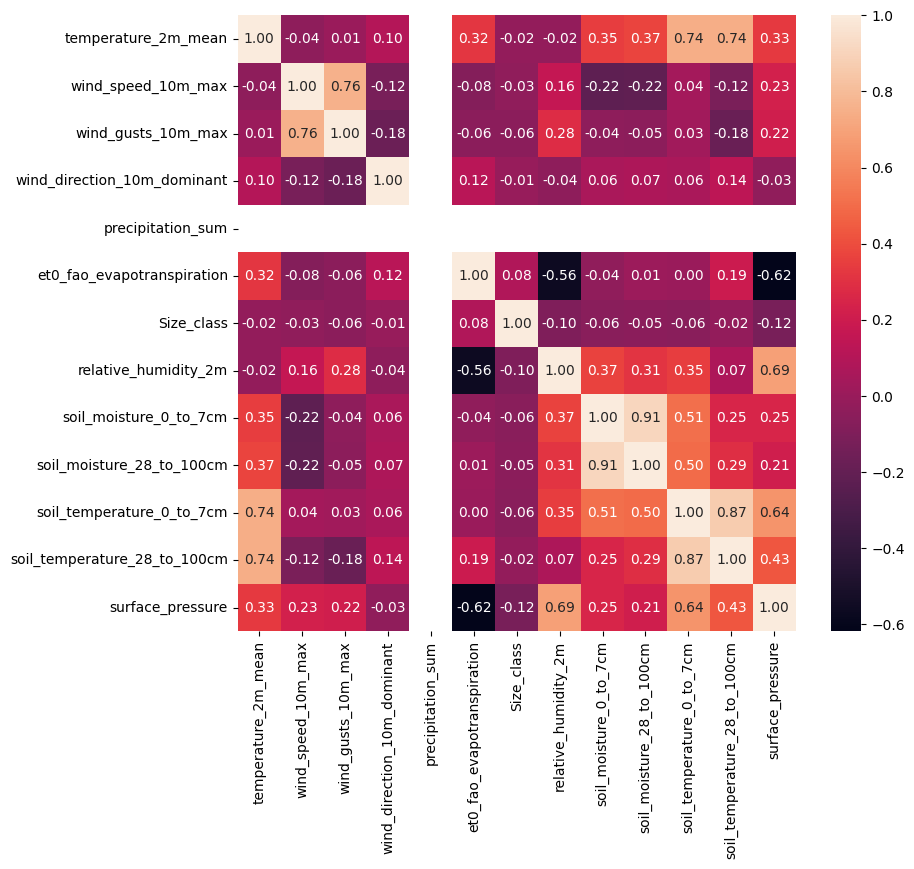

In [26]:
plt.figure(figsize=(9, 8))
sns.heatmap(daily_dataframe_agg.corr(numeric_only = True), annot=True, fmt = ".2f")
plt.show()

In [27]:
pd_X = daily_dataframe_agg.drop(['Size_class', 'date'], axis = 1)
pd_y = daily_dataframe_agg['Size_class']
X_train, X_test, y_train, y_test = train_test_split(pd_X, pd_y, test_size=0.2)

model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(model.score(X_test, y_test))

              precision    recall  f1-score   support

         0.0       0.33      0.08      0.13        12
         1.0       0.95      0.99      0.97       200

    accuracy                           0.94       212
   macro avg       0.64      0.54      0.55       212
weighted avg       0.91      0.94      0.92       212

0.9386792452830188


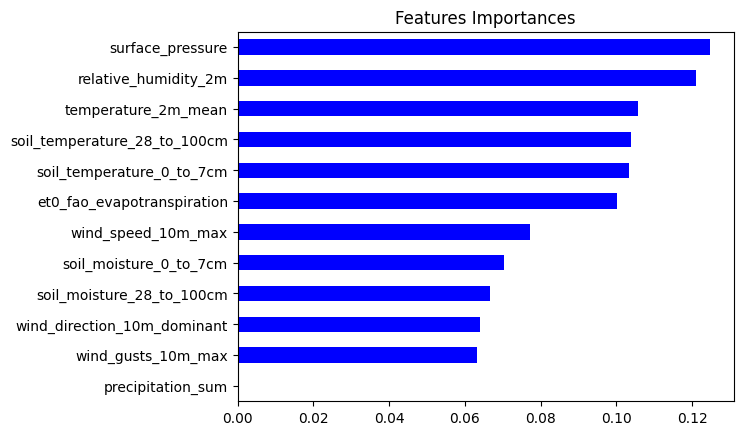

In [28]:
# Create a pd.Series of features importances
importances = pd.Series(data=model.feature_importances_,
                        index= X_train.columns)
# Sort importances
importances_sorted = importances.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='blue')
plt.title('Features Importances')
plt.show()